# Scaled Dot-Product Attention from Scratch


## 1. Theoretical Motivation: The Contextual Shift

The necessity for attention mechanisms arose to address a fundamental limitation in previous sequence models, such as Recurrent Neural Networks (RNNs) and static embeddings like Word2Vec. While effective for many tasks, RNNs suffered from a 'compression bottleneck': as they processed long input sequences, all information had to be compressed into a single fixed-size hidden state vector. This made it increasingly difficult for the model to retain relevant information from the beginning of the sequence as it reached the end, resulting in context loss and degraded performance on long-range dependencies.

On the other hand, static word embeddings (e.g., Word2Vec) generate a unique representation for each word regardless of its context. This is problematic for polysemous words—words with multiple meanings—where the same vector is forced to represent distinct senses, limiting the model's ability to capture subtle contextual nuances.

The **Self-Attention** mechanism, a key component of the Transformer architecture, revolutionized this approach. Instead of compressing the sequence into a single vector, attention allows the model to dynamically 'attend' to different parts of the input sequence when processing each element. Each token can weigh the importance of all other tokens to derive its own contextualized representation. This eliminates the compression bottleneck and enables the model to capture long-range dependencies efficiently while resolving semantic ambiguities through context-aware embeddings.

## 2. Mathematical Framework

The core operation of Scaled Dot-Product Attention is defined by the following formula:

$$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- **$Q$ (Query)**: A matrix representing the current token looking for context (Batch, Seq_Len, $d_k$).
- **$K$ (Key)**: A matrix representing all tokens in the sequence being searched (Batch, Seq_Len, $d_k$).
- **$V$ (Value)**: A matrix containing the information to be extracted (Batch, Seq_Len, $d_v$).
- **$d_k$**: The dimension of the keys/queries. The scaling factor $\sqrt{d_k}$ is critical for training stability: high dimensions can cause dot products to grow large, pushing the softmax into regions with extremely small gradients.

## 3. Core Implementation (PyTorch)


In [4]:
import torch
import torch.nn as nn
import math
import seaborn as sns
import matplotlib.pyplot as plt

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.head_dim = head_dim

        self.query_projection = nn.Linear(embed_dim, head_dim)
        self.key_projection = nn.Linear(embed_dim, head_dim)
        self.value_projection = nn.Linear(embed_dim, head_dim)

    def forward(self, x):
        # x shape: (Batch_Size, Seq_Len, Embed_Dim)

        query = self.query_projection(x)  # (Batch_Size, Seq_Len, Head_Dim)
        key = self.key_projection(x)      # (Batch_Size, Seq_Len, Head_Dim)
        value = self.value_projection(x)  # (Batch_Size, Seq_Len, Head_Dim)

        attention_scores = torch.matmul(query, key.transpose(-2, -1))

        scaled_attention_scores = attention_scores / math.sqrt(self.head_dim)

        attention_weights = torch.softmax(scaled_attention_scores, dim=-1)

        output = torch.matmul(attention_weights, value)

        return output, attention_weights # Return both output and attention_weights

print("SelfAttention class redefined to return attention weights.")

SelfAttention class redefined to return attention weights.


## 4. Contextual Awareness Experiment


In [3]:
import torch
import torch.nn.functional as F

# 1. Define a small vocabulary and initial embeddings
vocab = {
    "<pad>": 0,
    "the": 1,
    "bank": 2,
    "of": 3,
    "river": 4,
    "money": 5,
    "in": 6
}

# Reverse vocabulary for easier lookup
idx_to_word = {v: k for k, v in vocab.items()}

embed_dim = 64 # Dimension of word embeddings
head_dim = 64  # Dimension for Q, K, V projections (same as embed_dim for simplicity in this case)

# Create random initial embeddings for words in the vocabulary
# Ensure 'bank' has a single initial representation
embedding_layer = nn.Embedding(len(vocab), embed_dim)
# For reproducibility, we can fix the embeddings or ensure 'bank' is specifically identifiable

# Example of manually setting initial embeddings for demonstration purposes
# Let's say, 'bank' is at index 2
# For simplicity, let's use the embedding_layer.weight as our initial embeddings
initial_embeddings = embedding_layer.weight # (vocab_size, embed_dim)

print("Vocabulary and initial embeddings created.")

# 2. Define the two example sentences
sentence1_str = "the bank of the river"
sentence2_str = "money in the bank"

print(f"Sentence 1: {sentence1_str}")
print(f"Sentence 2: {sentence2_str}")

# 3. Convert each sentence into sequences of numerical indices
sentence1_indices = torch.tensor([vocab[word] for word in sentence1_str.split()])
sentence2_indices = torch.tensor([vocab[word] for word in sentence2_str.split()])

# Get initial embeddings for sentences
sentence1_embeds = embedding_layer(sentence1_indices).unsqueeze(0) # (1, Seq_Len, Embed_Dim)
sentence2_embeds = embedding_layer(sentence2_indices).unsqueeze(0) # (1, Seq_Len, Embed_Dim)

print(f"Initial embeddings for Sentence 1 shape: {sentence1_embeds.shape}")
print(f"Initial embeddings for Sentence 2 shape: {sentence2_embeds.shape}")

# 4. Process each sentence's embeddings through the SelfAttention class
sa_model = SelfAttention(embed_dim=embed_dim, head_dim=head_dim)

contextualized_s1 = sa_model(sentence1_embeds) # (1, Seq_Len, Head_Dim)
contextualized_s2 = sa_model(sentence2_embeds) # (1, Seq_Len, Head_Dim)

print(f"Contextualized embeddings for Sentence 1 shape: {contextualized_s1.shape}")
print(f"Contextualized embeddings for Sentence 2 shape: {contextualized_s2.shape}")

# 5. Extract the embedding for the word 'bank' from the initial embeddings
# Find index of 'bank' in each sentence
bank_idx_s1 = sentence1_str.split().index("bank")
bank_idx_s2 = sentence2_str.split().index("bank")

initial_bank_s1 = sentence1_embeds[0, bank_idx_s1, :]
initial_bank_s2 = sentence2_embeds[0, bank_idx_s2, :]

print(f"Initial 'bank' embedding for Sentence 1: {initial_bank_s1[:5].detach().numpy()}...") # show first 5 elements
print(f"Initial 'bank' embedding for Sentence 2: {initial_bank_s2[:5].detach().numpy()}...")

# 6. Extract the contextualized embedding for the word 'bank'
contextualized_bank_s1 = contextualized_s1[0, bank_idx_s1, :]
contextualized_bank_s2 = contextualized_s2[0, bank_idx_s2, :]

print(f"Contextualized 'bank' embedding for Sentence 1: {contextualized_bank_s1[:5].detach().numpy()}...")
print(f"Contextualized 'bank' embedding for Sentence 2: {contextualized_bank_s2[:5].detach().numpy()}...")

# 7. Calculate Cosine Similarity between initial 'bank' embeddings
cosine_sim_initial = F.cosine_similarity(initial_bank_s1, initial_bank_s2, dim=0)

# 8. Calculate Cosine Similarity between contextualized 'bank' embeddings
cosine_sim_contextualized = F.cosine_similarity(contextualized_bank_s1, contextualized_bank_s2, dim=0)

# 9. Print results
print(f"\n--- Cosine Similarity Results ---")
print(f"Cosine Similarity between initial 'bank' embeddings: {cosine_sim_initial.item():.4f}")
print(f"Cosine Similarity between contextualized 'bank' embeddings: {cosine_sim_contextualized.item():.4f}")

if cosine_sim_initial.item() > cosine_sim_contextualized.item():
    print("\nObservation: The contextualized 'bank' embeddings are less similar, demonstrating the disambiguation effect.")
else:
    print("\nObservation: The contextualized 'bank' embeddings are more similar or equally similar. This might happen with random initializations or if the model hasn't learned meaningful context yet, or if the context doesn't sufficiently disambiguate in a single head setting.")


Vocabulary and initial embeddings created.
Sentence 1: the bank of the river
Sentence 2: money in the bank
Initial embeddings for Sentence 1 shape: torch.Size([1, 5, 64])
Initial embeddings for Sentence 2 shape: torch.Size([1, 4, 64])
Contextualized embeddings for Sentence 1 shape: torch.Size([1, 5, 64])
Contextualized embeddings for Sentence 2 shape: torch.Size([1, 4, 64])
Initial 'bank' embedding for Sentence 1: [ 0.03406394  0.33459863 -1.2664924   0.15586536 -0.43624848]...
Initial 'bank' embedding for Sentence 2: [ 0.03406394  0.33459863 -1.2664924   0.15586536 -0.43624848]...
Contextualized 'bank' embedding for Sentence 1: [ 0.0321717   0.16534907 -0.16841263 -0.3817508   0.30671382]...
Contextualized 'bank' embedding for Sentence 2: [ 0.05885372  0.14623055  0.31828013 -0.19093853  0.4661248 ]...

--- Cosine Similarity Results ---
Cosine Similarity between initial 'bank' embeddings: 1.0000
Cosine Similarity between contextualized 'bank' embeddings: 0.7055

Observation: The conte

## 5. Visualizing Attention Heads


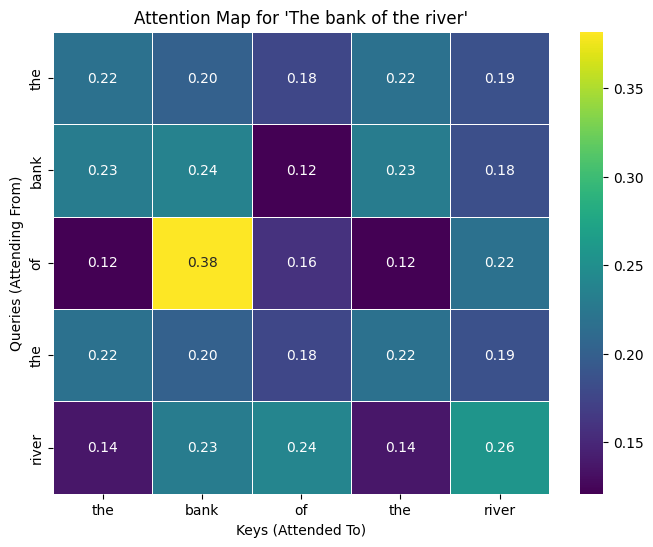

Attention heatmap generated for 'The bank of the river'.


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Re-instantiate the SelfAttention model since its definition changed
sa_model_viz = SelfAttention(embed_dim=embed_dim, head_dim=head_dim)

# Process sentence1 again to get attention weights
# embedding_layer and sentence1_indices are already defined from previous steps
sentence1_embeds = embedding_layer(sentence1_indices).unsqueeze(0) # (1, Seq_Len, Embed_Dim)

# Get output and attention weights from the modified model
contextualized_s1_viz, attention_weights_s1 = sa_model_viz(sentence1_embeds)

# Squeeze the batch dimension for plotting
attention_weights_s1 = attention_weights_s1.squeeze(0).detach().numpy() # (Seq_Len, Seq_Len)

# Get tokens for sentence1 to use as labels
sentence1_tokens = sentence1_str.split()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    attention_weights_s1,
    xticklabels=sentence1_tokens,
    yticklabels=sentence1_tokens,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=.5
)
plt.title("Attention Map for 'The bank of the river'")
plt.xlabel("Keys (Attended To)")
plt.ylabel("Queries (Attending From)")
plt.show()

print("Attention heatmap generated for 'The bank of the river'.")

## 6. Research Insights & Complexity Analysis

### The Quadratic Complexity Bottleneck $O(n^2)$

Despite its revolutionary capabilities, the Self-Attention architecture has an intrinsic computational limitation. The core operation calculating attention scores involves the matrix product $QK^T$, which for a sequence of length $n$ results in an $n \times n$ matrix. This implies that both computational cost and memory requirements scale quadratically with sequence length ($O(n^2)$). For massive contexts (e.g., long documents or high-resolution audio), this cost becomes prohibitive. Recent research focuses on sparse attention, linear transformers, or retrieval-based models to approximate this quadratic growth with linear or log-linear alternatives.

### Self-Attention vs. Cross-Attention

It is essential to distinguish between the two primary types of attention in the Transformer architecture:

1.  **Self-Attention**: The Query (Q), Key (K), and Value (V) all originate from the *same* input sequence. This allows the model to correlate different positions of a single sequence to compute a representation of that sequence.
2.  **Cross-Attention**: Used in Encoder-Decoder structures (like NMT), the Query (Q) comes from the decoder's current state, while the Key (K) and Value (V) come from the encoder's output. This creates a functional bridge, allowing the decoder to 'look back' at the source representation to generate the target sequence.